# Conditions

| Model               | FiveVTS | Chickenpox | Pedalme | Wikimath | Windmillsmall | MontevideoBus |
|---------------------|---------|------------|---------|----------|---------------|---------------|
| Max iter.           | 30      | 30         | 30      | 30       | 30            | 30            |
| Epochs              | 50      | 50         | 50      | 50       | 50            | 50            |
| Lags                | 2       | 4          | 4       | 8        | 8             | 4             |
| Interpolation       | linear  | linear     | nearest | linear   | linear        | nearest       |
| Filters             |         |            |         |          |               |               |
| GConvGRU            | 12      | 16         | 12      | 12       | 12            | 12            |
| GConvLSTM           | 12      | 32         | 2       | 64       | 16            | 12            |
| GCLSTM              | 4       | 16         | 4       | 64       | 16            | 12            |
| LRGCN               | 4       | 8          | 8       | 32       | 12            | 2             |
| DyGrEncoder         | 12      | 12         | 12      | 12       | 12            | 12            |
| EvolveGCNH          | No need | No need    | No need | No need  | No need       | No need       |
| EvolveGCNO          | No need | No need    | No need | No need  | No need       | No need       |
| TGCN                | 12      | 12         | 12      | 12       | 12            | 8             |
| DCRNN               | 2       | 16         | 8       | 12       | 4             | 12            |


In [420]:
df_dataset = pd.DataFrame([[i,0,0] for i in set(df.dataset)])
df_dataset.columns = ['dataset','node','time']

dataset_values = {
    'fivenodes': {'time': 200, 'node': 5},
    'chickenpox': {'time': 522, 'node': 20},
    'pedalme': {'time': 36, 'node': 15},
    'wikimath': {'time': 731, 'node': 1068},
    'windmillsmall': {'time': 17472, 'node': 11},
    'monte': {'time': 744, 'node': 675},
}

for dataset, values in dataset_values.items():
    df_dataset.loc[df_dataset['dataset'] == dataset, ['time', 'node']] = values.values()

df_dataset

df_dataset

dataset  node   time
0        pedalme    15     36
1       wikimath  1068    731
2          monte   675    744
3     chickenpox    20    522
4  windmillsmall    11  17472
5      fivenodes     5    200

# Import

In [112]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import pickle

import plotly.io as pio

In [113]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

# Data

In [114]:
df = pd.read_csv('../Data/Body_Results.csv').query("method!='GNAR'").iloc[:,1:]
df.head()

dataset    method  mrate mtype  lags  nof_filters inter_method  epoch  \
0  fivenodes     STGCN    0.0   NaN     2         12.0          NaN   50.0   
1  fivenodes     STGCN    0.0   NaN     2         12.0          NaN   50.0   
2  fivenodes  IT-STGCN    0.0   NaN     2         12.0          NaN   50.0   
3  fivenodes  IT-STGCN    0.0   NaN     2         12.0          NaN   50.0   
4  fivenodes     STGCN    0.0   NaN     2         12.0          NaN   50.0   

        mse  calculation_time     model  
0  0.729374         80.985221  GConvGRU  
1  0.729082         80.891788  GConvGRU  
2  0.731600        114.492592  GConvGRU  
3  0.735026        115.544274  GConvGRU  
4  0.727182        102.783140  GConvGRU

# 1

**Fivenodes 데이터 셋의 GConvGRU 모델에서 데이터의 결측값이 증가할수록 Classic 모델(여기선GConvGRU)에 비해 Proposed 모델의 error값이 확연히 느리게 증가하는 현상**

- 내용
    - 실험 결과에 대한 첫번 째 접근은 다음과 같다. Figure 1의 결과는 각 결측값 비율에 따라 정리한 `FiveVTS` 데이터셋에 대한 결과이며, 모델은 `GConvGRU`를 이용하였다. Classic과 Proposed는 결측값 비율이 점점 증가함에 따라, 평균제곱오차가 증가하는 경향을 보였다. 특히, Classic과 Proposed 각각에 대한 trendline을 비교해본 결과, 결측값 비율이 증가할 수록 Classic에 비해 우리가 제안한 방법((Proposed)의 평균제곱오차가 느리게 증가하는 경향을 띄었다. 반면, Classic 모델은 오히려 빠르게 증가하는 경향을 띄었다. 결측값 비율이 커질수록 우리가 제안하는 방법이 비교적 낮은 오차 내에서 값을 예측해낸다는 것을 알 수 있었다.
    - First approach is on Figure \ref{}. That showed the result using `FiveVTS` dataset and `GConvGRU` model by each missing rate. As the proportion of missing values gradually increases, there is a tendency for the MSE to rise. Especially, we compared values between Classic method(GConvGRU) and Proposed method. Both models indicate a similar trend; however, the MSE for the Classic method exhibits a rapid increase. Conversely, the MSE trend for the Proposed method shows a slower increase compared to the Classic approach.

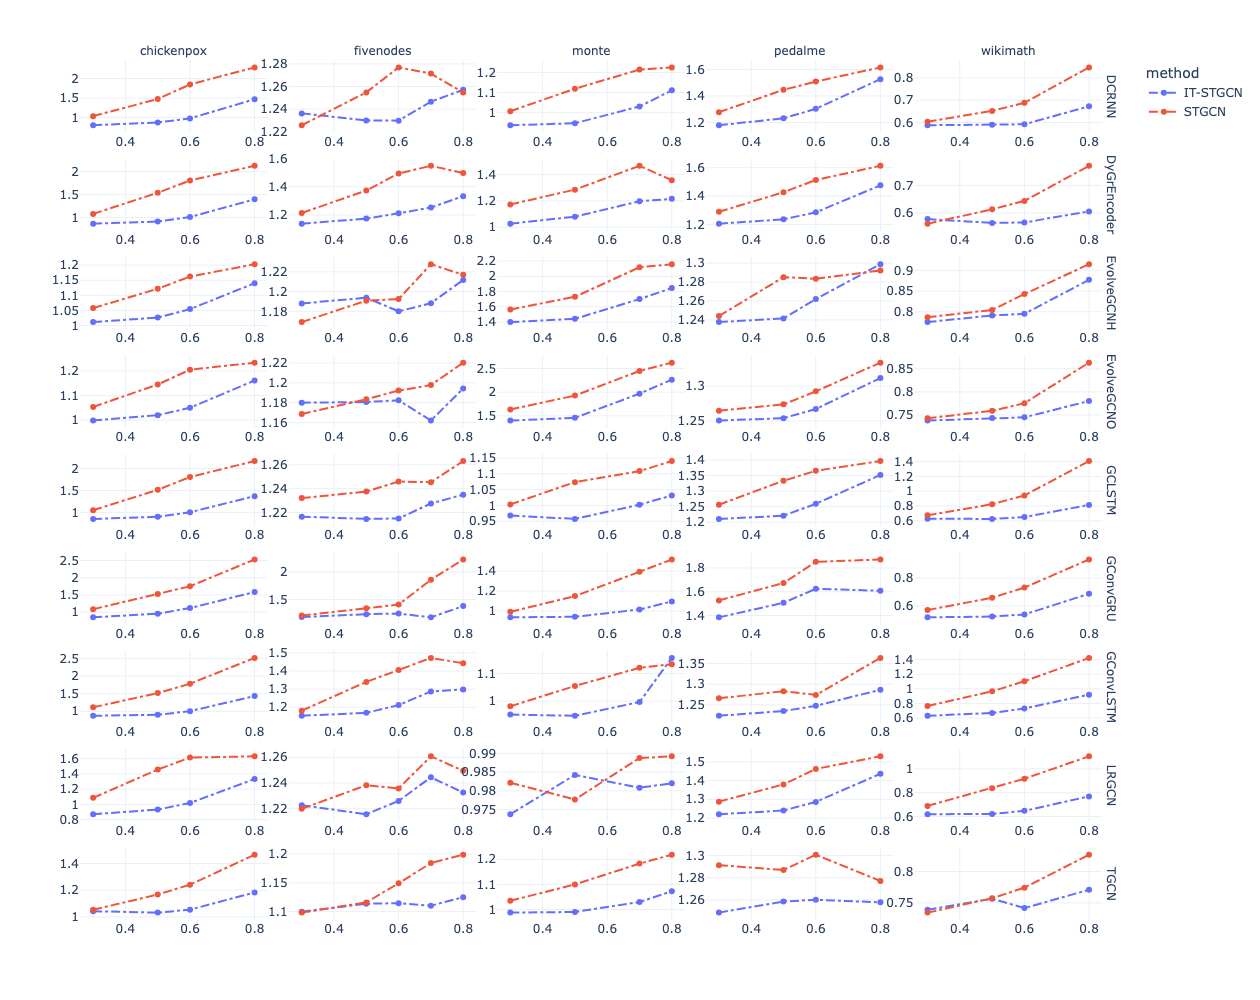

In [213]:
fig = df.query("mtype=='rand'").query("dataset != 'windmillsmall'")\
.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.plot.line(
    x='mrate',
    y='mse',
    color='method',
    facet_row='model',
    facet_col='dataset',
    width=750,
    height=1000,
    
)
for scatter in fig.data:
    scatter['mode'] = 'lines+markers'
    scatter['line']['dash'] = 'dashdot'
for annotation in fig.layout['annotations']:
    annotation['text'] = annotation['text'].replace('dataset=','')
    annotation['text'] = annotation['text'].replace('model=','')
for k in [k for k in fig.layout if 'xaxis' in k]:
    fig.layout[k]['title']['text'] = None 
for k in [k for k in fig.layout if 'yaxis' in k]:
    fig.layout[k]['title']['text'] = None 
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None)

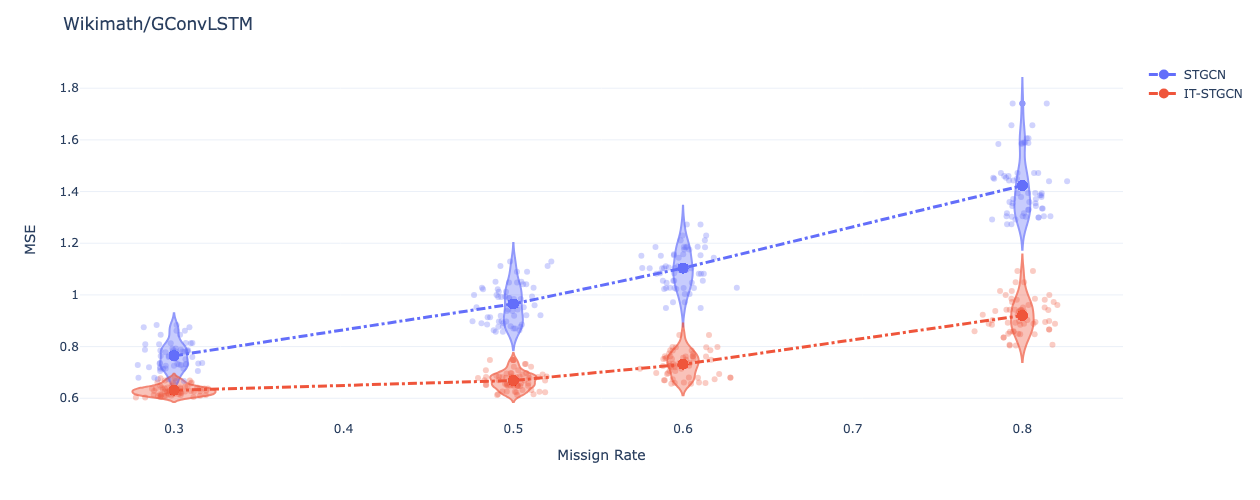

In [407]:
big = df.query("mtype=='rand'").query("dataset == 'wikimath'").query("model == 'GConvLSTM'").sort_values(by='mrate')\
.assign(mrate_jittered = lambda df: np.array(df['mrate'])+np.random.randn(len(df['mrate']))*0.01)
small = big.groupby(["dataset","mrate","method"]).agg({'mse':'mean'}).reset_index().rename({'mse':'mse_mean'},axis=1)
tidydata = big.merge(small)
fig = px.scatter(
    tidydata,
    y='mse',
    x='mrate_jittered',
    opacity=0.3,
    color='method',
    width=750,
    height=500,
)
_fig1 = px.scatter(
    tidydata,
    y='mse_mean',
    x='mrate',
    color='method',
)
_fig1.data[0]['mode']='markers+lines'
_fig1.data[0]['marker']['size'] = 10
_fig1.data[0]['line']['width'] = 3
_fig1.data[0]['line']['dash'] = 'dashdot'
_fig1.data[1]['mode']='markers+lines'
_fig1.data[1]['marker']['size'] = 10
_fig1.data[1]['line']['width'] = 3
_fig1.data[1]['line']['dash'] = 'dashdot'
_fig2 = px.violin(
    tidydata.query("method=='STGCN'"),
    y='mse',
    x='mrate',
)
_fig2.data[0]['opacity']=0.7
_fig2.data[0]['marker']['color']='#636efa'
_fig3 = px.violin(
    tidydata.query("method=='IT-STGCN'"),
    y='mse',
    x='mrate',
)
_fig3.data[0]['opacity']=0.7
_fig3.data[0]['marker']['color']='#EF553B'
_fig3
for g in _fig1.data:
    fig.add_trace(g)
for g in _fig2.data:
    fig.add_trace(g)
for g in _fig3.data:
    fig.add_trace(g)
fig.data[0]['showlegend'] =False
fig.data[1]['showlegend'] =False
fig.layout['xaxis']['title']['text']='Missign Rate'
fig.layout['yaxis']['title']['text']='MSE'
fig.layout['legend']['title']['text']=""
fig.layout['title']['text']='Wikimath/GConvLSTM'
fig

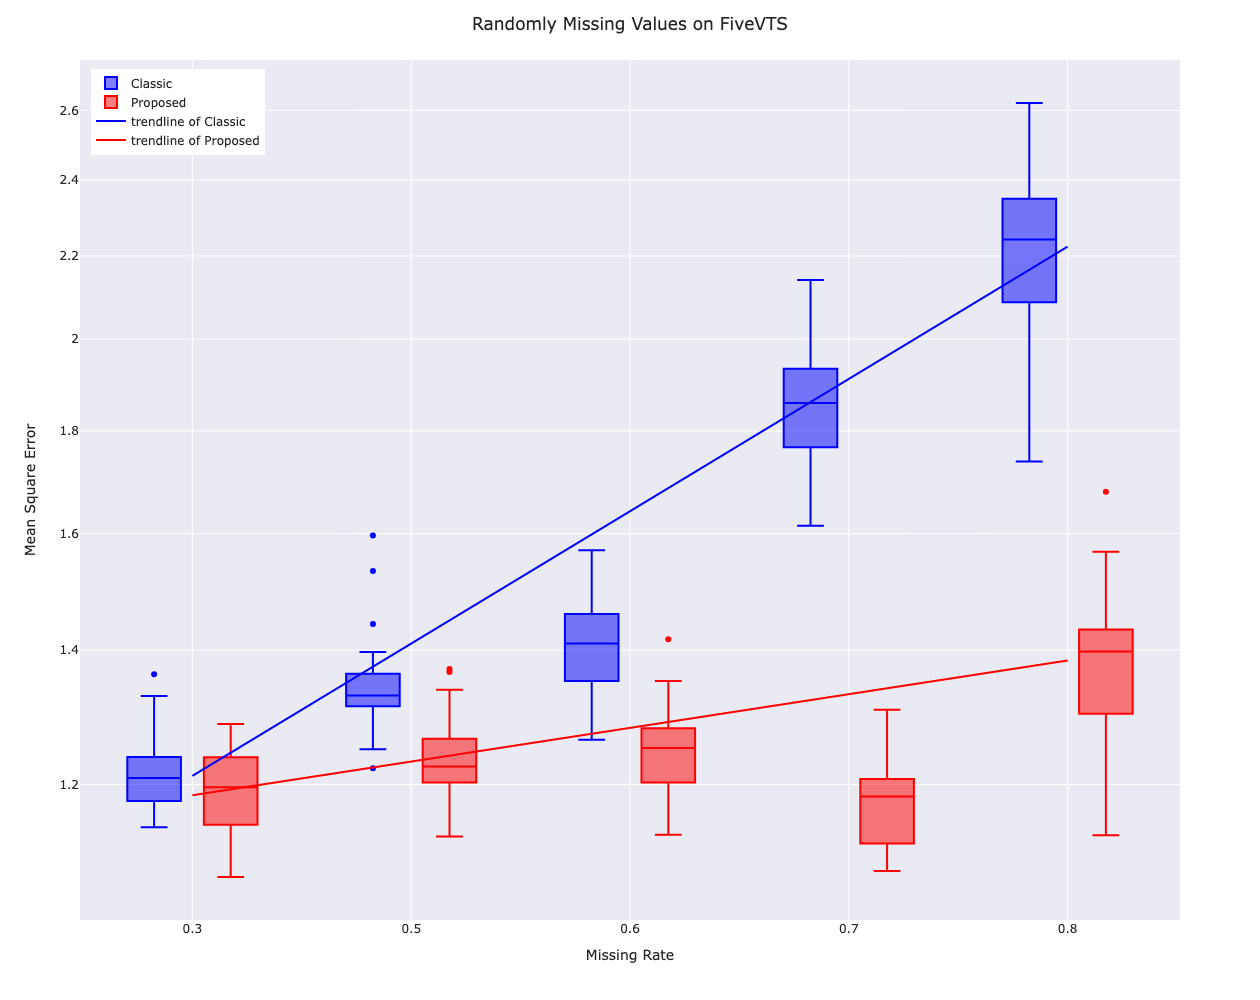

In [3]:
fig = px.box(tidydata,x='mrate',y='mse',color='method',width=70, log_y=True)


fig.layout['xaxis']['title']['text']='Missing Rate'
fig.layout['yaxis']['title']['text']='Mean Square Error'

fig.data[0]['marker']['color'] = 'blue'
fig.data[0]['name'] = 'Classic'

fig.data[1]['marker']['color'] = 'red'
fig.data[1]['name'] = 'Proposed'

fig.layout['legend']['title']=''

fig.update_layout(template="seaborn")
fig.update_layout(title_text="Randomly Missing Values on FiveVTS")
fig.update_layout(height=1000, width=1900)

# fig.add_trace(go.Scatter(x=['0.3', '0.8'], y=[(tidydata.query('mrate=="0.3"'))['mse'].mean(), (tidydata.query('mrate=="0.8"'))['mse'].mean()], 
#                          mode="lines", name="trendline", line=dict(color="black",width=2)))
fig.add_trace(go.Scatter(x=['0.3', '0.8'], y=[(tidydata.query('mrate=="0.3" and method=="STGCN"'))['mse'].mean(), (tidydata.query('mrate=="0.8" and method=="STGCN"'))['mse'].mean()], 
                         mode="lines", name="trendline of Classic", line=dict(color="blue",width=2)))
fig.add_trace(go.Scatter(x=['0.3', '0.8'], y=[(tidydata.query('mrate=="0.3" and method!="STGCN"'))['mse'].mean(), (tidydata.query('mrate=="0.8" and method!="STGCN"'))['mse'].mean()], 
                         mode="lines", name="trendline of Proposed", line=dict(color="red",width=2)))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig

# 2

**전개: GConvGRU 모델만이 아니라 다른 모델에서도 MSE가 Classic에 비해 Proposed가 낮게 나오는 trend**

- 내용
    - `1`의 내용에 대한 확장으로. `FiveVTS` 데이터 셋에서 `GConvGRU` 방법 이외에 시도한 다른 Classic 모델들에 대한 결과이다. `GConvGRU`, `GConvLSTM`, `GCLSTM`, `LRGCN`, `DyGrEncoder`, `EvolveGCNH`, `EvolveGCNO`, `TGCN`, `DCRNN` 모델의 결과이며. 첫번째 섹션에서 제시한 결과와 비슷하게 결측값 비율이 증가할 수록 예측값에 대한 오차가 증가하였으며. Proposed가 더 낮은 값을 띄는 경향을 보인 것을 확인할 수 있었다. 다른 데이터 셋에 대한 결과도 결측값이 증가할 수록 오차가 증가하되, 우리가 제안한 방법에 대한 mse값이 낮은 비슷한 경향을 보였으며, 나머지 모델에서 나온 6개의 데이터 셋에 대한 결과는 부록에서 확인할 수 있다.
    - According to Figure 111, we checked the tendency of MSE between Classic and Propsosed method while the missing rate is increasing. We try to research this trend can still show other classic models. Figure 222 depicts a similar pattern to Figure 111, indicating that as the missing rate increases, the MSE for the Proposed method outperforms that of the Classic method.

In [170]:
tidydata

Unnamed: 0    dataset    method mrate mtype  lags  nof_filters  \
1200         480  fivenodes     STGCN   0.3  rand     2         12.0   
1201         482  fivenodes  IT-STGCN   0.3  rand     2         12.0   
1202         484  fivenodes     STGCN   0.3  rand     2         12.0   
1203         486  fivenodes  IT-STGCN   0.3  rand     2         12.0   
1204         488  fivenodes     STGCN   0.3  rand     2         12.0   
...          ...        ...       ...   ...   ...   ...          ...   
1191         334  fivenodes  IT-STGCN   0.8  rand     2         12.0   
1193         340  fivenodes     STGCN   0.8  rand     2         12.0   
1195         346  fivenodes  IT-STGCN   0.8  rand     2         12.0   
1197         352  fivenodes     STGCN   0.8  rand     2         12.0   
1199         358  fivenodes  IT-STGCN   0.8  rand     2         12.0   

     inter_method  epoch       mse  calculation_time     model  
1200       linear   50.0  1.144046         64.093816  GConvGRU  
1201       linear   50.0  1.237942         78.395827  GConvGRU  
1202       linear   50.0  1.238811         66.592592  GConvGRU  
1203       linear   50.0  1.197841         61.475358  GConvGRU  
1204       linear   50.0  1.361561         59.974841  GConvGRU  
...           ...    ...       ...               ...       ...  
1191       linear   50.0  1.389617        141.511231  GConvGRU  
1193       linear   50.0  2.284089        117.776922  GConvGRU  
1195       linear   50.0  1.466322        134.535171  GConvGRU  
1197       linear   50.0  2.162257        115.434279  GConvGRU  
1199       linear   50.0  1.451803        139.474553  GConvGRU  

[300 rows x 12 columns]

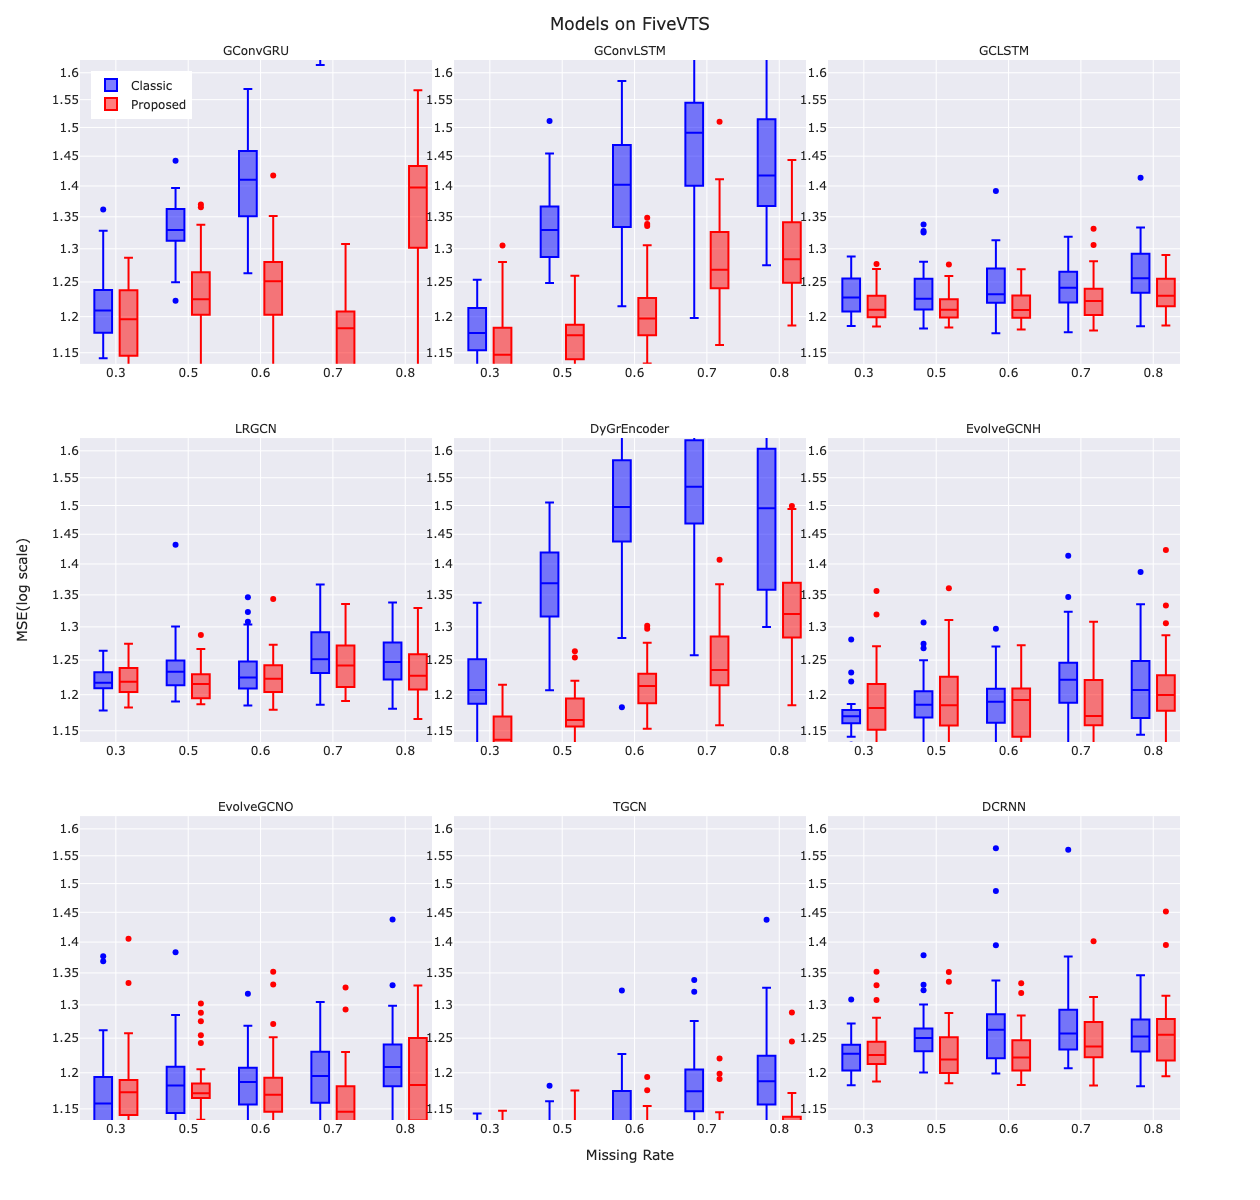

In [181]:
# tidydata = pd.concat([
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvGRU') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvLSTM') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==4) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='GCLSTM') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==4) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='LRGCN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='DyGrEncoder') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['lags']==2) & 
#        (df['epoch']==50) & (df['model']=='EvolveGCNH') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['lags']==2) & 
#        (df['epoch']==50) & (df['model']=='EvolveGCNO') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='TGCN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
#     df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==2) & 
#        (df['lags']==2) & (df['epoch']==50) & (df['model']=='DCRNN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))]
# ])
tidydata = pd.DataFrame(df.query("dataset=='fivenodes' and mtype=='rand'"))

tidydata['model'] = pd.Categorical(tidydata['model'], categories=["GConvGRU", "GConvLSTM", "GCLSTM", "LRGCN", "DyGrEncoder", "EvolveGCNH", "EvolveGCNO", "TGCN", "DCRNN"])
tidydata['method'] = pd.Categorical(tidydata['method'], categories=['STGCN', 'IT-STGCN'])

tidydata['mrate'] = tidydata['mrate'].astype(str)
tidydata = tidydata.sort_values(by=['model','mrate'])

fig = px.box(tidydata,x='mrate',y='mse',color='method',log_y=True,facet_col='model',facet_col_wrap=3)

fig.layout['xaxis']['title']['text']=''
fig.layout['xaxis2']['title']['text']='Missing Rate'
fig.layout['xaxis3']['title']['text']=''
fig.layout['yaxis']['title']['text']=''
fig.layout['yaxis4']['title']['text']='MSE(log scale)'
fig.layout['yaxis7']['title']['text']=''
fig.layout['legend']['title']='Method'

fig.layout.xaxis4.showticklabels=True
fig.layout.xaxis5.showticklabels=True
fig.layout.xaxis6.showticklabels=True
fig.layout.xaxis7.showticklabels=True
fig.layout.xaxis8.showticklabels=True
fig.layout.xaxis9.showticklabels=True

fig.layout.yaxis2.showticklabels=True
fig.layout.yaxis3.showticklabels=True
fig.layout.yaxis5.showticklabels=True
fig.layout.yaxis6.showticklabels=True
fig.layout.yaxis8.showticklabels=True
fig.layout.yaxis9.showticklabels=True

fig.layout['legend']['title']=''

for i in range(0, 9):
    fig.data[i]['marker']['color'] = 'blue'
    fig.data[i]['name'] = 'Classic'
for i in range(9, 18):    
    fig.data[i]['marker']['color'] = 'red'
    fig.data[i]['name'] = 'Proposed'

fig.update_layout(legend=dict(x=1, y=1, traceorder='normal', orientation='v'))
fig.update_layout(template="seaborn")
fig.update_layout(title_text="Models on FiveVTS")
fig.update_layout(height=1200, width=1900)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig
# with open('fivenodes_fig.pkl', 'wb') as file:
#     pickle.dump(fig, file)
# with open('fivenodes_fig.pkl', 'rb') as file:
#     fivenodes_fig = pickle.load(file)

# fivenodes_fig

# 3

**Missing rate이 높을 떄(70% 혹은 80%), GConvGRU를 예로 들어 데이터 셋마다 모두 Proposed method의 mse가 더 낮은 것 확인**

- 내용
    - 이번 섹션에서는 데이터의 다양성을 고려하기 위하여 사용된 총 6개의 데이터에 대해 결측값 비율이 높을때(70% 혹은 80%) `GConvGRU` 모델에서 예측과 제안된 방법의 비교 결과를 제시하였다. 대부분의 데이터셋의 결과는 Classic 모델보다 Proposed 결과의 mse 값이 낮게 분포되어 있음을 확인하였다.
    - We already showed that the MSE for Peoposed method is mostly lower than Classic methods on missing rate high. In detail, this section set the condition that missing rate high(70% or 80%). The model is GConvGRU on Figure 333. All of six datasets have lower MSE of Proposed method than Classic one. This lead to the fact out method would be helpful when we use real-world data which often has lots of missing values.

In [361]:
tidydata = pd.concat([df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
           (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvGRU') & (df['mrate'].isin([0.8]))],
        df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.8)"),
          df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.8)"),
          df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='GConvGRU' & (mrate == 0.8)"),
          df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='GConvGRU' & (mrate == 0.7)"),
          df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.8)")])

# tidydata = df.query("dataset=='fivenodes' and mtype=='rand' and mrate in [0.7,0.8]")
tidydata['model'] = pd.Categorical(tidydata['model'], categories=["GConvGRU", "GConvLSTM", "GCLSTM", "LRGCN", "DyGrEncoder", "EvolveGCNH", "EvolveGCNO", "TGCN", "DCRNN"])
categories=["fivenodes", "chickenpox", "pedalme", "wikimath", "windmillsmall", "monte"]
tidydata['method'] = pd.Categorical(tidydata['method'], categories=['STGCN', 'IT-STGCN'])

tidydata = tidydata.sort_values(by='dataset', key=lambda x: x.map({dataset: i for i, dataset in enumerate(categories)}))

fig = px.strip(tidydata,x='dataset',y='mse',color='method', log_y=True,stripmode='overlay')

fig.layout['xaxis']['title']['text']=''
fig.layout['xaxis2']['title']['text']=''
fig.layout['xaxis3']['title']['text']='Missing Rate'
fig.layout['xaxis4']['title']['text']=''
fig.layout['xaxis5']['title']['text']=''
fig.layout['xaxis6']['title']['text']=''

fig.layout['yaxis']['title']['text']='MSE(log scale)'

fig.layout.yaxis2.showticklabels=True
fig.layout.yaxis3.showticklabels=True
fig.layout.yaxis4.showticklabels=True
fig.layout.yaxis5.showticklabels=True
fig.layout.yaxis6.showticklabels=True

# fig.layout.annotations[0].text = 'FiveVTS'
# fig.layout.annotations[1].text = 'Chickenpox'
# fig.layout.annotations[2].text = 'Pedalme'
# fig.layout.annotations[3].text = 'Wikimath'
# fig.layout.annotations[4].text = 'Windmillsmall'
# fig.layout.annotations[5].text = 'MontevideoBus'

fig.layout['legend']['title']=''

for i in range(0, 6):
    fig.data[i]['marker']['color'] = 'blue'
    fig.data[i]['name'] = 'Classic'
for i in range(6, 12):    
    fig.data[i]['marker']['color'] = 'red'
    fig.data[i]['name'] = 'Proposed'

fig.update_layout(template="seaborn")
fig.update_layout(title_text="GConvGRU on datasets")
# fig.update_yaxes(matches=None)
fig.update_layout(height=800, width=1900)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

PlotlyKeyError: Invalid property specified for object of type plotly.graph_objs.Layout: 'xaxis2'

Did you mean "xaxis"?

    Valid properties:
        activeselection
            :class:`plotly.graph_objects.layout.Activeselection`
            instance or dict with compatible properties
        activeshape
            :class:`plotly.graph_objects.layout.Activeshape`
            instance or dict with compatible properties
        annotations
            A tuple of
            :class:`plotly.graph_objects.layout.Annotation`
            instances or dicts with compatible properties
        annotationdefaults
            When used in a template (as
            layout.template.layout.annotationdefaults), sets the
            default property values to use for elements of
            layout.annotations
        autosize
            Determines whether or not a layout width or height that
            has been left undefined by the user is initialized on
            each relayout. Note that, regardless of this attribute,
            an undefined layout width or height is always
            initialized on the first call to plot.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. This is the default
            value; however it could be overridden for individual
            axes.
        bargap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        bargroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        barmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "relative", the bars
            are stacked on top of one another, with negative values
            below the axis, positive values above With "group", the
            bars are plotted next to one another centered around
            the shared location. With "overlay", the bars are
            plotted over one another, you might need to reduce
            "opacity" to see multiple bars.
        barnorm
            Sets the normalization for bar traces on the graph.
            With "fraction", the value of each bar is divided by
            the sum of all values at that location coordinate.
            "percent" is the same but multiplied by 100 to show
            percentages.
        boxgap
            Sets the gap (in plot fraction) between boxes of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        boxgroupgap
            Sets the gap (in plot fraction) between boxes of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        boxmode
            Determines how boxes at the same location coordinate
            are displayed on the graph. If "group", the boxes are
            plotted next to one another centered around the shared
            location. If "overlay", the boxes are plotted over one
            another, you might need to set "opacity" to see them
            multiple boxes. Has no effect on traces that have
            "width" set.
        calendar
            Sets the default calendar system to use for
            interpreting and displaying dates throughout the plot.
        clickmode
            Determines the mode of single click interactions.
            "event" is the default value and emits the
            `plotly_click` event. In addition this mode emits the
            `plotly_selected` event in drag modes "lasso" and
            "select", but with no event data attached (kept for
            compatibility reasons). The "select" flag enables
            selecting single data points via click. This mode also
            supports persistent selections, meaning that pressing
            Shift while clicking, adds to / subtracts from an
            existing selection. "select" with `hovermode`: "x" can
            be confusing, consider explicitly setting `hovermode`:
            "closest" when using this feature. Selection events are
            sent accordingly as long as "event" flag is set as
            well. When the "event" flag is missing, `plotly_click`
            and `plotly_selected` events are not fired.
        coloraxis
            :class:`plotly.graph_objects.layout.Coloraxis` instance
            or dict with compatible properties
        colorscale
            :class:`plotly.graph_objects.layout.Colorscale`
            instance or dict with compatible properties
        colorway
            Sets the default trace colors.
        computed
            Placeholder for exporting automargin-impacting values
            namely `margin.t`, `margin.b`, `margin.l` and
            `margin.r` in "full-json" mode.
        datarevision
            If provided, a changed value tells `Plotly.react` that
            one or more data arrays has changed. This way you can
            modify arrays in-place rather than making a complete
            new copy for an incremental change. If NOT provided,
            `Plotly.react` assumes that data arrays are being
            treated as immutable, thus any data array with a
            different identity from its predecessor contains new
            data.
        dragmode
            Determines the mode of drag interactions. "select" and
            "lasso" apply only to scatter traces with markers or
            text. "orbit" and "turntable" apply only to 3D scenes.
        editrevision
            Controls persistence of user-driven changes in
            `editable: true` configuration, other than trace names
            and axis titles. Defaults to `layout.uirevision`.
        extendfunnelareacolors
            If `true`, the funnelarea slice colors (whether given
            by `funnelareacolorway` or inherited from `colorway`)
            will be extended to three times its original length by
            first repeating every color 20% lighter then each color
            20% darker. This is intended to reduce the likelihood
            of reusing the same color when you have many slices,
            but you can set `false` to disable. Colors provided in
            the trace, using `marker.colors`, are never extended.
        extendiciclecolors
            If `true`, the icicle slice colors (whether given by
            `iciclecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendpiecolors
            If `true`, the pie slice colors (whether given by
            `piecolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendsunburstcolors
            If `true`, the sunburst slice colors (whether given by
            `sunburstcolorway` or inherited from `colorway`) will
            be extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        extendtreemapcolors
            If `true`, the treemap slice colors (whether given by
            `treemapcolorway` or inherited from `colorway`) will be
            extended to three times its original length by first
            repeating every color 20% lighter then each color 20%
            darker. This is intended to reduce the likelihood of
            reusing the same color when you have many slices, but
            you can set `false` to disable. Colors provided in the
            trace, using `marker.colors`, are never extended.
        font
            Sets the global font. Note that fonts used in traces
            and other layout components inherit from the global
            font.
        funnelareacolorway
            Sets the default funnelarea slice colors. Defaults to
            the main `colorway` used for trace colors. If you
            specify a new list here it can still be extended with
            lighter and darker colors, see
            `extendfunnelareacolors`.
        funnelgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        funnelgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        funnelmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "stack", the bars are
            stacked on top of one another With "group", the bars
            are plotted next to one another centered around the
            shared location. With "overlay", the bars are plotted
            over one another, you might need to reduce "opacity" to
            see multiple bars.
        geo
            :class:`plotly.graph_objects.layout.Geo` instance or
            dict with compatible properties
        grid
            :class:`plotly.graph_objects.layout.Grid` instance or
            dict with compatible properties
        height
            Sets the plot's height (in px).
        hiddenlabels
            hiddenlabels is the funnelarea & pie chart analog of
            visible:'legendonly' but it can contain many labels,
            and can simultaneously hide slices from several
            pies/funnelarea charts
        hiddenlabelssrc
            Sets the source reference on Chart Studio Cloud for
            `hiddenlabels`.
        hidesources
            Determines whether or not a text link citing the data
            source is placed at the bottom-right cored of the
            figure. Has only an effect only on graphs that have
            been generated via forked graphs from the Chart Studio
            Cloud (at https://chart-studio.plotly.com or on-
            premise).
        hoverdistance
            Sets the default distance (in pixels) to look for data
            to add hover labels (-1 means no cutoff, 0 means no
            looking for data). This is only a real distance for
            hovering on point-like objects, like scatter points.
            For area-like objects (bars, scatter fills, etc)
            hovering is on inside the area and off outside, but
            these objects will not supersede hover on point-like
            objects in case of conflict.
        hoverlabel
            :class:`plotly.graph_objects.layout.Hoverlabel`
            instance or dict with compatible properties
        hovermode
            Determines the mode of hover interactions. If
            "closest", a single hoverlabel will appear for the
            "closest" point within the `hoverdistance`. If "x" (or
            "y"), multiple hoverlabels will appear for multiple
            points at the "closest" x- (or y-) coordinate within
            the `hoverdistance`, with the caveat that no more than
            one hoverlabel will appear per trace. If *x unified*
            (or *y unified*), a single hoverlabel will appear
            multiple points at the closest x- (or y-) coordinate
            within the `hoverdistance` with the caveat that no more
            than one hoverlabel will appear per trace. In this
            mode, spikelines are enabled by default perpendicular
            to the specified axis. If false, hover interactions are
            disabled.
        iciclecolorway
            Sets the default icicle slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendiciclecolors`.
        images
            A tuple of :class:`plotly.graph_objects.layout.Image`
            instances or dicts with compatible properties
        imagedefaults
            When used in a template (as
            layout.template.layout.imagedefaults), sets the default
            property values to use for elements of layout.images
        legend
            :class:`plotly.graph_objects.layout.Legend` instance or
            dict with compatible properties
        mapbox
            :class:`plotly.graph_objects.layout.Mapbox` instance or
            dict with compatible properties
        margin
            :class:`plotly.graph_objects.layout.Margin` instance or
            dict with compatible properties
        meta
            Assigns extra meta information that can be used in
            various `text` attributes. Attributes such as the
            graph, axis and colorbar `title.text`, annotation
            `text` `trace.name` in legend items, `rangeselector`,
            `updatemenus` and `sliders` `label` text all support
            `meta`. One can access `meta` fields using template
            strings: `%{meta[i]}` where `i` is the index of the
            `meta` item in question. `meta` can also be an object
            for example `{key: value}` which can be accessed
            %{meta[key]}.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        minreducedheight
            Minimum height of the plot with margin.automargin
            applied (in px)
        minreducedwidth
            Minimum width of the plot with margin.automargin
            applied (in px)
        modebar
            :class:`plotly.graph_objects.layout.Modebar` instance
            or dict with compatible properties
        newselection
            :class:`plotly.graph_objects.layout.Newselection`
            instance or dict with compatible properties
        newshape
            :class:`plotly.graph_objects.layout.Newshape` instance
            or dict with compatible properties
        paper_bgcolor
            Sets the background color of the paper where the graph
            is drawn.
        piecolorway
            Sets the default pie slice colors. Defaults to the main
            `colorway` used for trace colors. If you specify a new
            list here it can still be extended with lighter and
            darker colors, see `extendpiecolors`.
        plot_bgcolor
            Sets the background color of the plotting area in-
            between x and y axes.
        polar
            :class:`plotly.graph_objects.layout.Polar` instance or
            dict with compatible properties
        scattergap
            Sets the gap (in plot fraction) between scatter points
            of adjacent location coordinates. Defaults to `bargap`.
        scattermode
            Determines how scatter points at the same location
            coordinate are displayed on the graph. With "group",
            the scatter points are plotted next to one another
            centered around the shared location. With "overlay",
            the scatter points are plotted over one another, you
            might need to reduce "opacity" to see multiple scatter
            points.
        scene
            :class:`plotly.graph_objects.layout.Scene` instance or
            dict with compatible properties
        selectdirection
            When `dragmode` is set to "select", this limits the
            selection of the drag to horizontal, vertical or
            diagonal. "h" only allows horizontal selection, "v"
            only vertical, "d" only diagonal and "any" sets no
            limit.
        selectionrevision
            Controls persistence of user-driven changes in selected
            points from all traces.
        selections
            A tuple of
            :class:`plotly.graph_objects.layout.Selection`
            instances or dicts with compatible properties
        selectiondefaults
            When used in a template (as
            layout.template.layout.selectiondefaults), sets the
            default property values to use for elements of
            layout.selections
        separators
            Sets the decimal and thousand separators. For example,
            *. * puts a '.' before decimals and a space between
            thousands. In English locales, dflt is ".," but other
            locales may alter this default.
        shapes
            A tuple of :class:`plotly.graph_objects.layout.Shape`
            instances or dicts with compatible properties
        shapedefaults
            When used in a template (as
            layout.template.layout.shapedefaults), sets the default
            property values to use for elements of layout.shapes
        showlegend
            Determines whether or not a legend is drawn. Default is
            `true` if there is a trace to show and any of these: a)
            Two or more traces would by default be shown in the
            legend. b) One pie trace is shown in the legend. c) One
            trace is explicitly given with `showlegend: true`.
        sliders
            A tuple of :class:`plotly.graph_objects.layout.Slider`
            instances or dicts with compatible properties
        sliderdefaults
            When used in a template (as
            layout.template.layout.sliderdefaults), sets the
            default property values to use for elements of
            layout.sliders
        smith
            :class:`plotly.graph_objects.layout.Smith` instance or
            dict with compatible properties
        spikedistance
            Sets the default distance (in pixels) to look for data
            to draw spikelines to (-1 means no cutoff, 0 means no
            looking for data). As with hoverdistance, distance does
            not apply to area-like objects. In addition, some
            objects can be hovered on but will not generate
            spikelines, such as scatter fills.
        sunburstcolorway
            Sets the default sunburst slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendsunburstcolors`.
        template
            Default attributes to be applied to the plot. This
            should be a dict with format: `{'layout':
            layoutTemplate, 'data': {trace_type: [traceTemplate,
            ...], ...}}` where `layoutTemplate` is a dict matching
            the structure of `figure.layout` and `traceTemplate` is
            a dict matching the structure of the trace with type
            `trace_type` (e.g. 'scatter'). Alternatively, this may
            be specified as an instance of
            plotly.graph_objs.layout.Template.  Trace templates are
            applied cyclically to traces of each type. Container
            arrays (eg `annotations`) have special handling: An
            object ending in `defaults` (eg `annotationdefaults`)
            is applied to each array item. But if an item has a
            `templateitemname` key we look in the template array
            for an item with matching `name` and apply that
            instead. If no matching `name` is found we mark the
            item invisible. Any named template item not referenced
            is appended to the end of the array, so this can be
            used to add a watermark annotation or a logo image, for
            example. To omit one of these items on the plot, make
            an item with matching `templateitemname` and `visible:
            false`.
        ternary
            :class:`plotly.graph_objects.layout.Ternary` instance
            or dict with compatible properties
        title
            :class:`plotly.graph_objects.layout.Title` instance or
            dict with compatible properties
        titlefont
            Deprecated: Please use layout.title.font instead. Sets
            the title font. Note that the title's font used to be
            customized by the now deprecated `titlefont` attribute.
        transition
            Sets transition options used during Plotly.react
            updates.
        treemapcolorway
            Sets the default treemap slice colors. Defaults to the
            main `colorway` used for trace colors. If you specify a
            new list here it can still be extended with lighter and
            darker colors, see `extendtreemapcolors`.
        uirevision
            Used to allow user interactions with the plot to
            persist after `Plotly.react` calls that are unaware of
            these interactions. If `uirevision` is omitted, or if
            it is given and it changed from the previous
            `Plotly.react` call, the exact new figure is used. If
            `uirevision` is truthy and did NOT change, any
            attribute that has been affected by user interactions
            and did not receive a different value in the new figure
            will keep the interaction value. `layout.uirevision`
            attribute serves as the default for `uirevision`
            attributes in various sub-containers. For finer control
            you can set these sub-attributes directly. For example,
            if your app separately controls the data on the x and y
            axes you might set `xaxis.uirevision=*time*` and
            `yaxis.uirevision=*cost*`. Then if only the y data is
            changed, you can update `yaxis.uirevision=*quantity*`
            and the y axis range will reset but the x axis range
            will retain any user-driven zoom.
        uniformtext
            :class:`plotly.graph_objects.layout.Uniformtext`
            instance or dict with compatible properties
        updatemenus
            A tuple of
            :class:`plotly.graph_objects.layout.Updatemenu`
            instances or dicts with compatible properties
        updatemenudefaults
            When used in a template (as
            layout.template.layout.updatemenudefaults), sets the
            default property values to use for elements of
            layout.updatemenus
        violingap
            Sets the gap (in plot fraction) between violins of
            adjacent location coordinates. Has no effect on traces
            that have "width" set.
        violingroupgap
            Sets the gap (in plot fraction) between violins of the
            same location coordinate. Has no effect on traces that
            have "width" set.
        violinmode
            Determines how violins at the same location coordinate
            are displayed on the graph. If "group", the violins are
            plotted next to one another centered around the shared
            location. If "overlay", the violins are plotted over
            one another, you might need to set "opacity" to see
            them multiple violins. Has no effect on traces that
            have "width" set.
        waterfallgap
            Sets the gap (in plot fraction) between bars of
            adjacent location coordinates.
        waterfallgroupgap
            Sets the gap (in plot fraction) between bars of the
            same location coordinate.
        waterfallmode
            Determines how bars at the same location coordinate are
            displayed on the graph. With "group", the bars are
            plotted next to one another centered around the shared
            location. With "overlay", the bars are plotted over one
            another, you might need to reduce "opacity" to see
            multiple bars.
        width
            Sets the plot's width (in px).
        xaxis
            :class:`plotly.graph_objects.layout.XAxis` instance or
            dict with compatible properties
        yaxis
            :class:`plotly.graph_objects.layout.YAxis` instance or
            dict with compatible properties
        
Did you mean "xaxis"?


# 4

**DCRNN 모델의 wikimath 데이터에서 결측값 비율이 낮을 때 대비 높을 때 비교**

- 결측값 비율이 커지니 차이가 커진 mse 값 분포

- 내용
    - wikimath 데이터셋에서 DCRNN 결과에 대하여 결측값 비율이 작은 경우(30%) 대비 큰 경(80%)에 대하여 비교해보았다. wikimath 데이터셋에서 결측값을 주지 않았을떄, mse 값은 0.936±0.002(mean±sd)와 같았다. figure에서 보다시피, 결측값 비율이 30%으로 작을 때는 오차값이 작게 증가하였지만, 결측값의 비율이 80%로 높아졌을떄는 mse값이 확연히 높아진 것을 확인할 수 있었으며, 특히 classic 보다 proposed 의 값이 낮은 모습도 확인할 수 있었다.
    

<ipython-input-191-a5c67f96099c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-191-a5c67f96099c>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



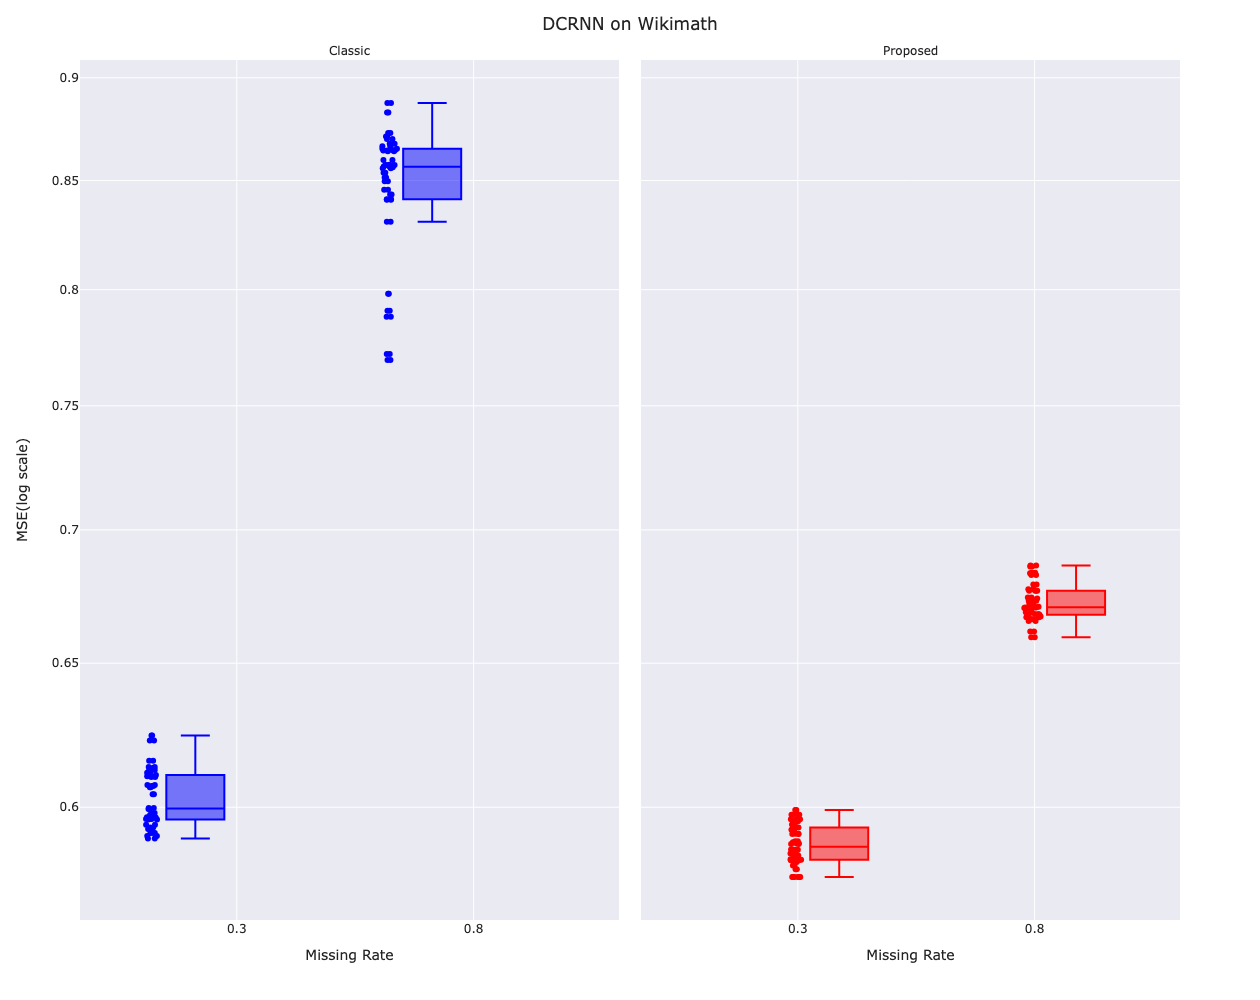

In [191]:
# tidydata = pd.concat([df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
#            (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvGRU') & (df['mrate'].isin([0.3,0.8]))]])
tidydata = df.query("model=='DCRNN' and dataset=='wikimath' and mrate in [0.3,0.8]")
tidydata['method'] = pd.Categorical(tidydata['method'], categories=['STGCN', 'IT-STGCN'])

tidydata['mrate'] = tidydata['mrate'].astype(str)
tidydata = tidydata.sort_values(by=['model','mrate'])

fig = px.box(tidydata,x='mrate',y='mse',width=10, points='all',log_y=True,facet_col='method')

fig.layout['xaxis2']['title']['text']='Missing Rate'
fig.layout['xaxis']['title']['text']='Missing Rate'
fig.layout['yaxis']['title']['text']='MSE(log scale)'

fig.data[0]['marker']['color'] = 'blue'
fig.data[1]['marker']['color'] = 'red'
fig.layout['legend']['title']=''

fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.update_layout(template="seaborn")
fig.update_layout(title_text="DCRNN on Wikimath")
fig.update_layout(height=1000, width=1500)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))

fig

# 5

**time이 적은 pedalme 데이터와 time이 많은 windmillsmall 데이터의 결측값 비율이 높을 때(70% 혹은 80%) 비교**

- 내용 
    - 이 섹션에서는 train 데이터 양에 따라 학습 결과를 논의해보고자 한다. 데이터가 적은 pedalme(node=15, time=36) 데이터는 proposed method 가 dramatic한 낮은 error값을 보이지 않았다. 반면에 time이 긴 windmillsmall(node=11, time=17472)은 proposed method가 결측값이 많을 때 mse 값이 낮게 나온 모습을 볼 수 있었다. underline function을 추정하여 true 겂을 따라가려는 우리 방법론이 효율적이기 위해서 데이터 양이 많을 경우가 좋다. time이 길거나(예를 들어 오랜 기간 어떤 기계의 센서에서 측정된 값) node가 많은(측정 지점이 많은) 경우가 실제 시공간 데이터의 경우 많을 것을 기대하기 떄문에, proposed의 효과가 있을 경우가 존재할 것이다.
    - According to the table (dataset explanation), the time for the 'Pedalme' dataset is 36, while the time for the 'Windmillsmall' dataset is 17,472. Thus, the two datasets have different amounts of data. We compared between two datasets, and the result is on Figure 555. The variations observed in Figure 555 for each dataset indicate that the disparity between methods is relatively small for the 'Pedalme' dataset, whereas the difference is more pronounced for the 'Windmillsmall' dataset.This phenomenon arises as the increasing quantity of data facilitates learning patterns and trends. Consequently, our approach signifies its effectiveness when there is a substantial amount of data in the time aspect. 

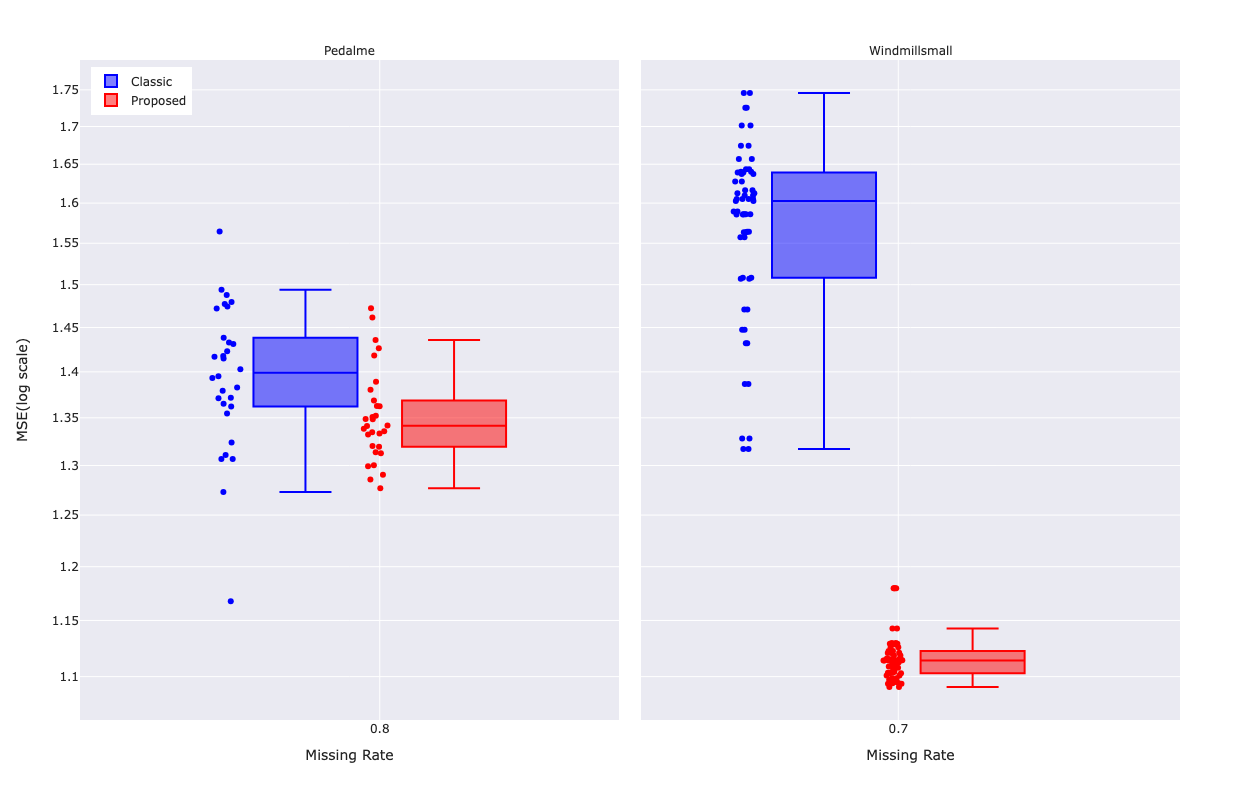

In [205]:
tidydata = pd.concat([
          df.query("dataset=='pedalme' & mtype=='rand'  & model=='GCLSTM' & (mrate == 0.8)"),
          df.query("dataset=='windmillsmall' & mtype=='rand' &  model=='GCLSTM' & (mrate == 0.7)")])

tidydata['method'] = pd.Categorical(tidydata['method'], categories=['STGCN', 'IT-STGCN'])

tidydata = tidydata.sort_values(by=['dataset','model','mrate'])

fig = px.box(tidydata,x='mrate',y='mse',color='method',width=70, log_y=True,facet_col='dataset', points="all")

fig.layout['xaxis']['title']['text']='Missing Rate'
fig.layout['xaxis2']['title']['text']='Missing Rate'
fig.layout['yaxis']['title']['text']='MSE(log scale)'

fig.data[0]['marker']['color'] = 'blue'
fig.data[0]['name'] = 'Classic'
fig.data[1]['marker']['color'] = 'blue'
fig.data[1]['name'] = 'Classic'
fig.data[2]['marker']['color'] = 'red'
fig.data[2]['name'] = 'Proposed'
fig.data[3]['marker']['color'] = 'red'
fig.data[3]['name'] = 'Proposed'

fig.layout.annotations[0].text = 'Pedalme'
fig.layout.annotations[1].text = 'Windmillsmall'

fig.layout['legend']['title']=''

fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=800, width=1800)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))

fig

In [330]:
fivenodes = pd.concat([
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvGRU') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='GConvLSTM') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==4) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='GCLSTM') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==4) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='LRGCN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='DyGrEncoder') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['lags']==2) & 
       (df['epoch']==50) & (df['model']=='EvolveGCNH') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['lags']==2) & 
       (df['epoch']==50) & (df['model']=='EvolveGCNO') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==12) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='TGCN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))],
    df[(df['dataset']=='fivenodes') & (df['mtype']=='rand') & (df['inter_method']=='linear') & (df['nof_filters']==2) & 
       (df['lags']==2) & (df['epoch']==50) & (df['model']=='DCRNN') & (df['mrate'].isin([0.3, 0.5, 0.6, 0.7, 0.8]))]
])
fivenodes['nodes'] = 5
fivenodes['time'] = 200
fivenodes = fivenodes.query("mrate==0.8")

chickenpox = pd.concat([
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==32 & lags==4 & epoch==50 & model=='GConvLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==4 & epoch==50 & model=='GCLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==8 & lags==4 & epoch==50 & model=='LRGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==4 & epoch==50 & model=='DyGrEncoder' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & lags==4 & epoch==50 & model=='EvolveGCNH' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & lags==4 & epoch==50 & model=='EvolveGCNO' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==4 & epoch==50 & model=='TGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==4 & epoch==50 & model=='DCRNN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)")
])
chickenpox['nodes'] = 20
chickenpox['time'] = 522
chickenpox = chickenpox.query("mrate==0.8")

pedalme = pd.concat([
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==2 & lags==4 & epoch==50 & model=='GConvLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==4 & lags==4 & epoch==50 & model=='GCLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==8 & lags==4 & epoch==50 & model=='LRGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='DyGrEncoder' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & lags==4 & epoch==50 & model=='EvolveGCNH' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & lags==4 & epoch==50 & model=='EvolveGCNO' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='TGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==8 & lags==4 & epoch==50 & model=='DCRNN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)")
], ignore_index=True)
pedalme['nodes'] = 15
pedalme['time'] = 36
pedalme = pedalme.query("mrate==0.8")

wikimath = pd.concat([
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='GConvGRU' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==64 & lags==8 & epoch==50 & model=='GConvLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==64 & lags==8 & epoch==50 & model=='GCLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==32 & lags==8 & epoch==50 & model=='LRGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='DyGrEncoder' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & lags==8 & epoch==50 & model=='EvolveGCNH' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & lags==8 & epoch==50 & model=='EvolveGCNO' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='TGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)"),
    df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='DCRNN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.8)")
], ignore_index=True)
wikimath['nodes'] = 1068
wikimath['time'] = 731
wikimath = wikimath.query("mrate==0.8")

windmillsmall = pd.concat([
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='GConvGRU' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==8 & epoch==50 & model=='GConvLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==8 & epoch==50 & model=='GCLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='LRGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='DyGrEncoder' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & lags==8 & epoch==50 & model=='EvolveGCNH' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & lags==8 & epoch==50 & model=='EvolveGCNO' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='TGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)"),
    df.query("dataset=='windmillsmall' & mtype=='rand' & inter_method == 'linear' & nof_filters==4 & lags==8 & epoch==50 & model=='DCRNN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.6 | mrate == 0.7)")
], ignore_index=True)
windmillsmall['nodes'] = 11
windmillsmall['time'] = 17472
windmillsmall = windmillsmall.query("mrate==0.7")

monte = pd.concat([
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GCLSTM' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==2 & lags==4 & epoch==50 & model=='LRGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='DyGrEncoder' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & lags==4 & epoch==50 & model=='EvolveGCNH' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & lags==4 & epoch==50 & model=='EvolveGCNO' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==8 & lags==4 & epoch==50 & model=='TGCN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)"),
    df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='DCRNN' & (mrate == 0.3 | mrate == 0.5 | mrate == 0.7 | mrate == 0.8)")
], ignore_index=True)
monte['nodes'] = 675
monte['time'] = 744
monte = monte.query("mrate==0.8")

tidydata = pd.concat([fivenodes, chickenpox, pedalme, wikimath,windmillsmall, monte])

tidydata['model'] = pd.Categorical(tidydata['model'], categories=["GConvGRU", "GConvLSTM", "GCLSTM", "LRGCN", "DyGrEncoder", "EvolveGCNH", "EvolveGCNO", "TGCN", "DCRNN"])
tidydata['method'] = pd.Categorical(tidydata['method'], categories=['STGCN', 'IT-STGCN'])


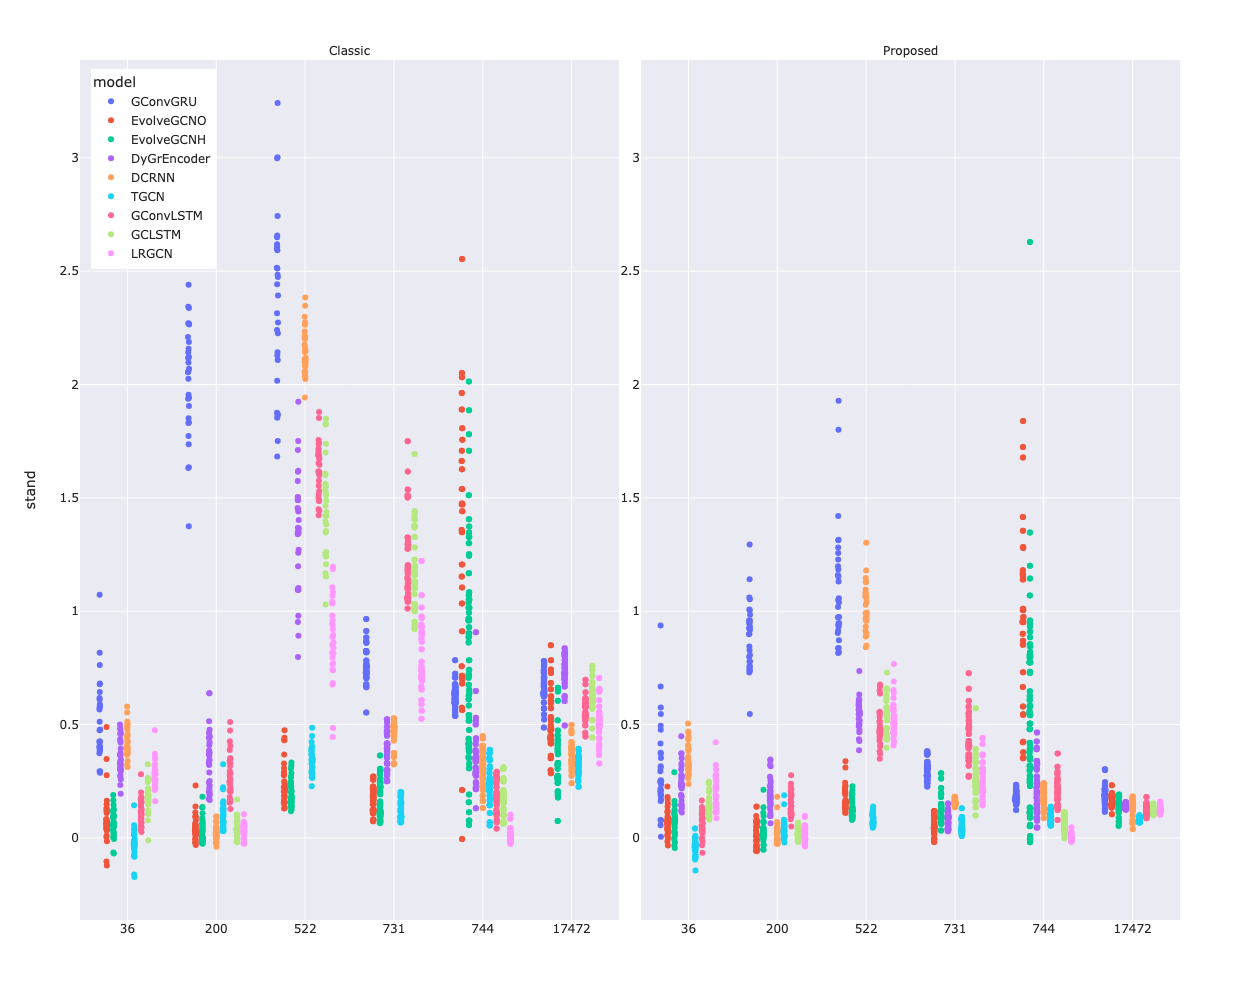

In [331]:
tmp=df.query("mrate==0").groupby(['dataset', 'model'], as_index=False)['mse'].mean().rename(columns={'mse': 'base_mse'})
new = pd.merge(tidydata, tmp, on=['dataset', 'model'], how='inner')
new['stand'] = (new['mse']-new['base_mse'])/new['base_mse']
new = new.sort_values(by=['time'], ascending=[True])

new['time'] = new['time'].astype(str)
new['nodes'] = new['nodes'].astype(str)

new['model'] = pd.Categorical(new['model'], categories=["GConvGRU", "GConvLSTM", "GCLSTM", "LRGCN", "DyGrEncoder", "EvolveGCNH", "EvolveGCNO", "TGCN", "DCRNN"])
new['method'] = pd.Categorical(new['method'], categories=['STGCN', 'IT-STGCN'])

fig = px.strip(new,x='time',y='stand',color='model',facet_col='method')
fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.xaxis.title.text = ''
fig.layout.xaxis2.title.text = ''

fig.layout.yaxis2.showticklabels = True

fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=1000, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

# 6

**points로 missing rate이 증가할 수록 mse trend를 method별로 비교**

- classic에 비해 proposed의 mse trend 계수가 낮음

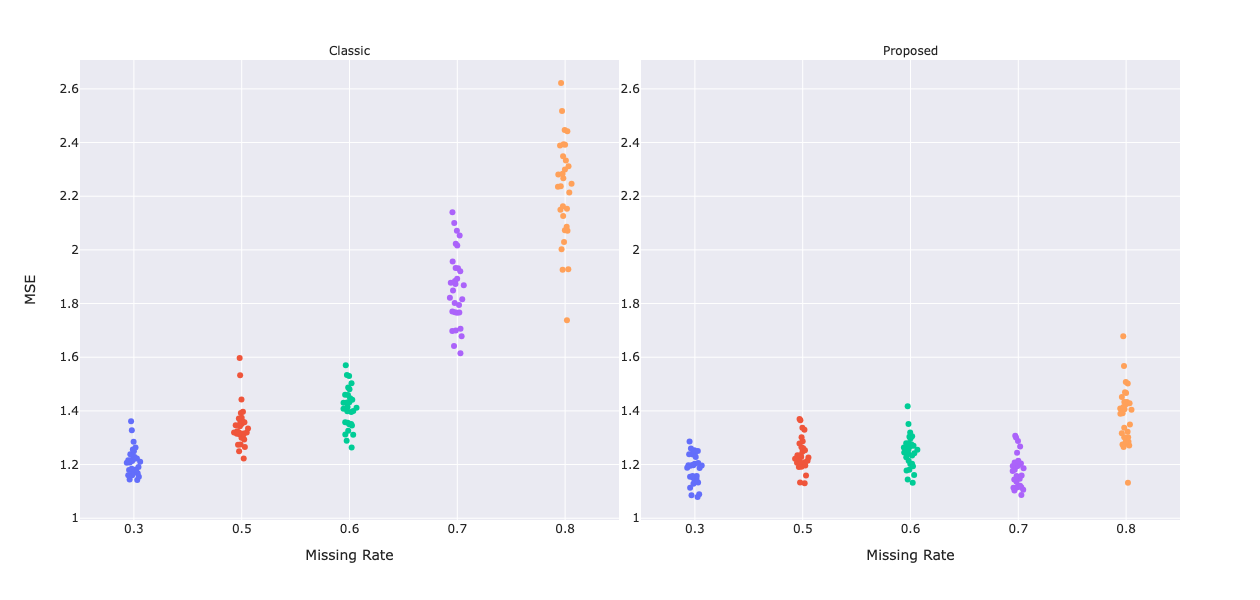

In [13]:
tidydata = pd.concat([df.query('dataset=="fivenodes" and model=="GConvGRU" and mtype=="rand"')])
tidydata = tidydata.sort_values(by=['model', 'mrate'], ascending=[True, True])

tidydata['mrate'] = tidydata['mrate'].astype(str)

fig = px.strip(tidydata, x='mrate', y="mse", color='mrate', facet_col='method')

fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.xaxis.title.text = 'Missing Rate'
fig.layout.xaxis2.title.text = 'Missing Rate'
fig.layout.yaxis.title.text = 'MSE'

fig.layout.yaxis2.showticklabels = True
fig.update_layout(showlegend=False)
fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=600, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

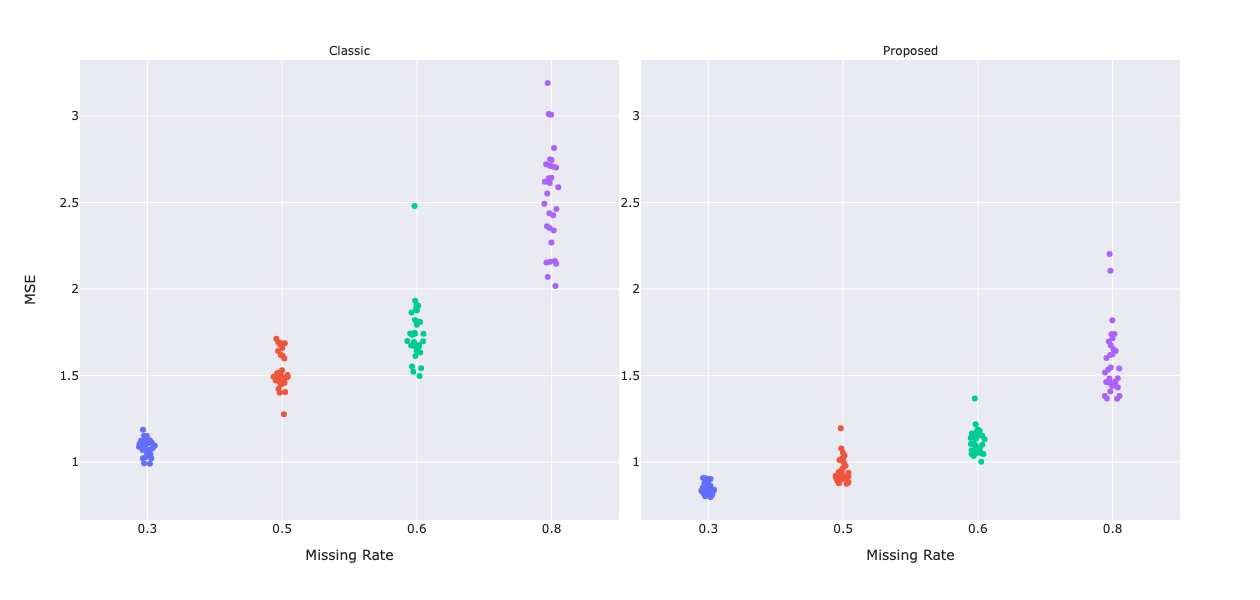

In [14]:
tidydata = pd.concat([df.query("dataset=='chickenpox' & mtype=='rand' & inter_method == 'linear' & nof_filters==16 & lags==4 & epoch==50 & model=='GConvGRU' and mtype=='rand'")])
tidydata = tidydata.sort_values(by=['model', 'mrate'], ascending=[True, True])
tidydata['mrate'] = tidydata['mrate'].astype(str)

fig = px.strip(tidydata, x='mrate', y="mse", color='mrate',facet_col='method')

fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.xaxis.title.text = 'Missing Rate'
fig.layout.xaxis2.title.text = 'Missing Rate'
fig.layout.yaxis.title.text = 'MSE'

fig.layout.yaxis2.showticklabels = True
fig.update_layout(showlegend=False)
fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=600, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

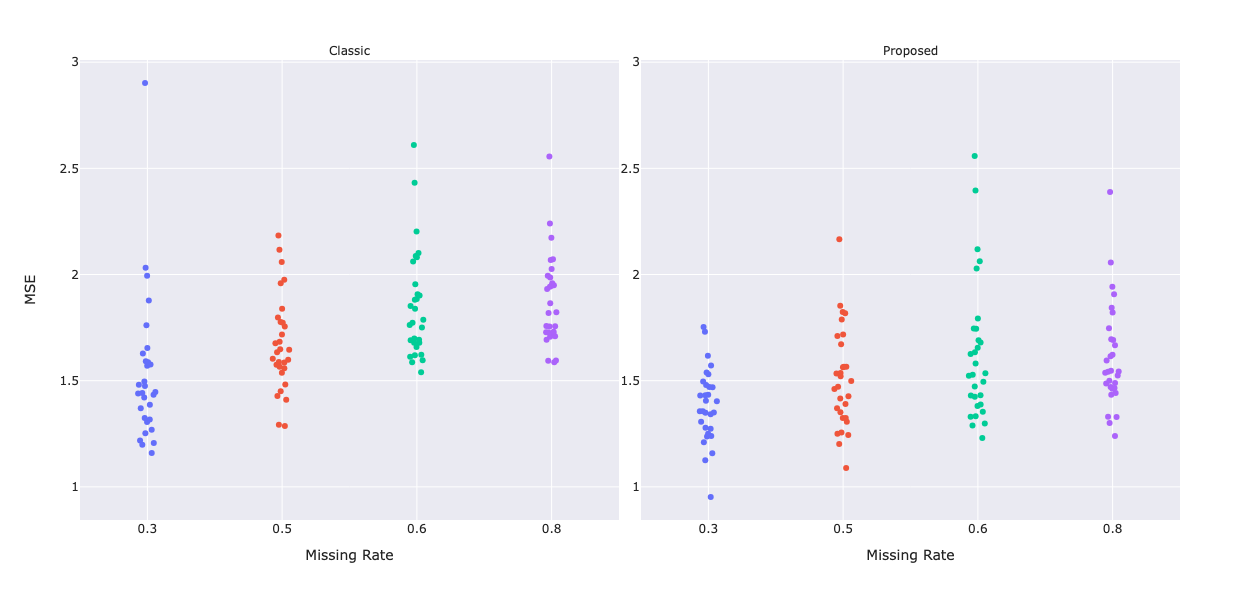

In [15]:
tidydata = pd.concat([df.query("dataset=='pedalme' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & mtype=='rand'")])
tidydata = tidydata.sort_values(by=['model', 'mrate'], ascending=[True, True])
tidydata['mrate'] = tidydata['mrate'].astype(str)

fig = px.strip(tidydata, x='mrate', y="mse", color='mrate',facet_col='method')

fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.yaxis2.showticklabels = True

fig.layout.xaxis.title.text = 'Missing Rate'
fig.layout.xaxis2.title.text = 'Missing Rate'
fig.layout.yaxis.title.text = 'MSE'

fig.update_layout(showlegend=False)
fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=600, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

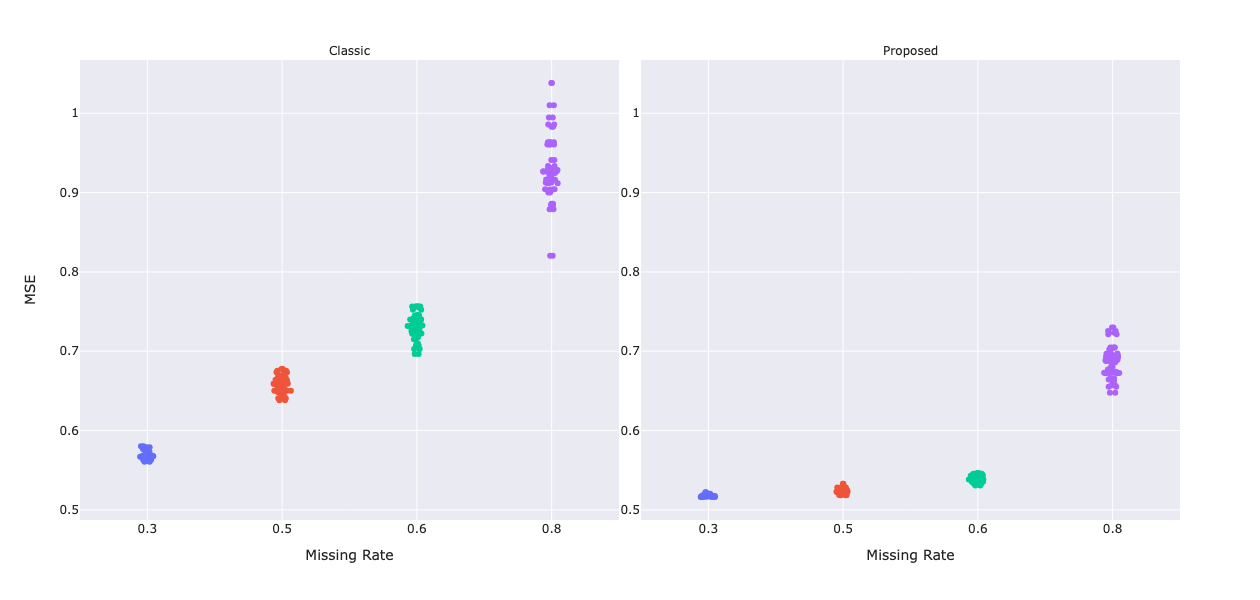

In [16]:
tidydata = pd.concat([df.query("dataset=='wikimath' & mtype=='rand' & inter_method == 'linear' & nof_filters==12 & lags==8 & epoch==50 & model=='GConvGRU' & mtype=='rand'")])
tidydata = tidydata.sort_values(by=['model', 'mrate'], ascending=[True, True])
tidydata['mrate'] = tidydata['mrate'].astype(str)

fig = px.strip(tidydata, x='mrate', y="mse",color='mrate',facet_col='method')

fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.xaxis.title.text = 'Missing Rate'
fig.layout.xaxis2.title.text = 'Missing Rate'
fig.layout.yaxis.title.text = 'MSE'

fig.update_layout(showlegend=False)

fig.layout.yaxis2.showticklabels = True

fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=600, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

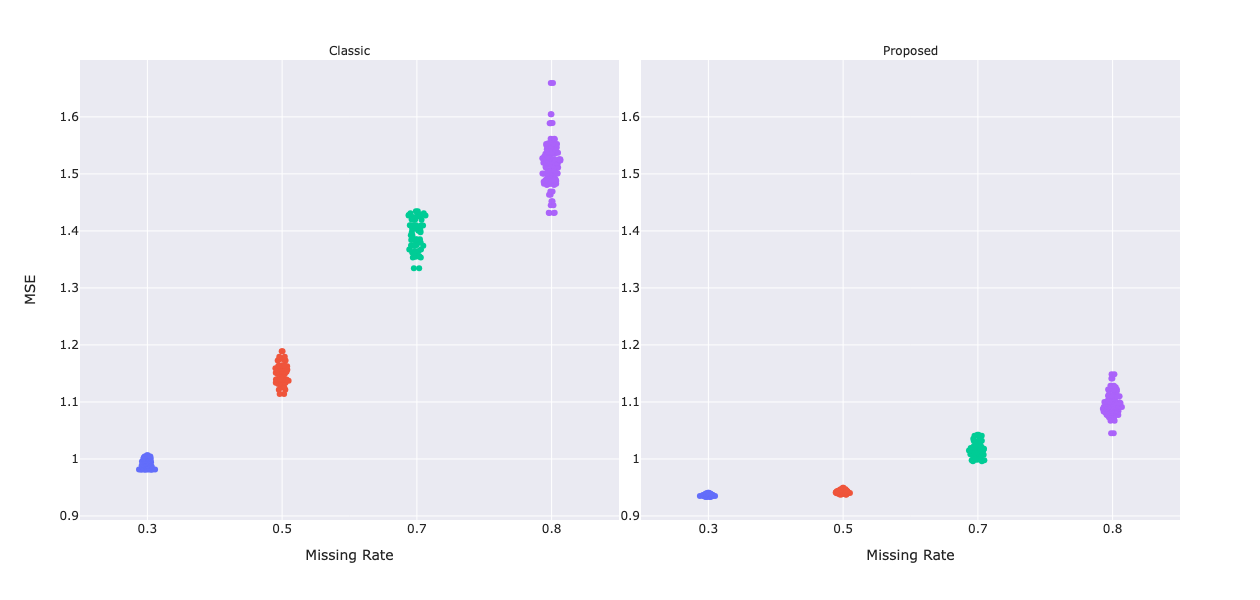

In [22]:
tidydata = pd.concat([df.query("dataset=='monte' & mtype=='rand' & inter_method == 'nearest' & nof_filters==12 & lags==4 & epoch==50 & model=='GConvGRU' & mtype=='rand'")])
tidydata = tidydata.sort_values(by=['model', 'mrate'], ascending=[True, True])
tidydata['mrate'] = tidydata['mrate'].astype(str)

fig = px.strip(tidydata, x='mrate', y="mse", color='mrate', facet_col='method')


fig.layout.annotations[0].text = 'Classic'
fig.layout.annotations[1].text = 'Proposed'

fig.layout.xaxis.title.text = 'Missing Rate'
fig.layout.xaxis2.title.text = 'Missing Rate'
fig.layout.yaxis.title.text = 'MSE'

fig.update_layout(showlegend=False)

fig.layout.yaxis2.showticklabels = True

fig.update_layout(template="seaborn")
fig.update_layout(title_text="")
fig.update_layout(height=600, width=1800)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
 ))
fig

# 7

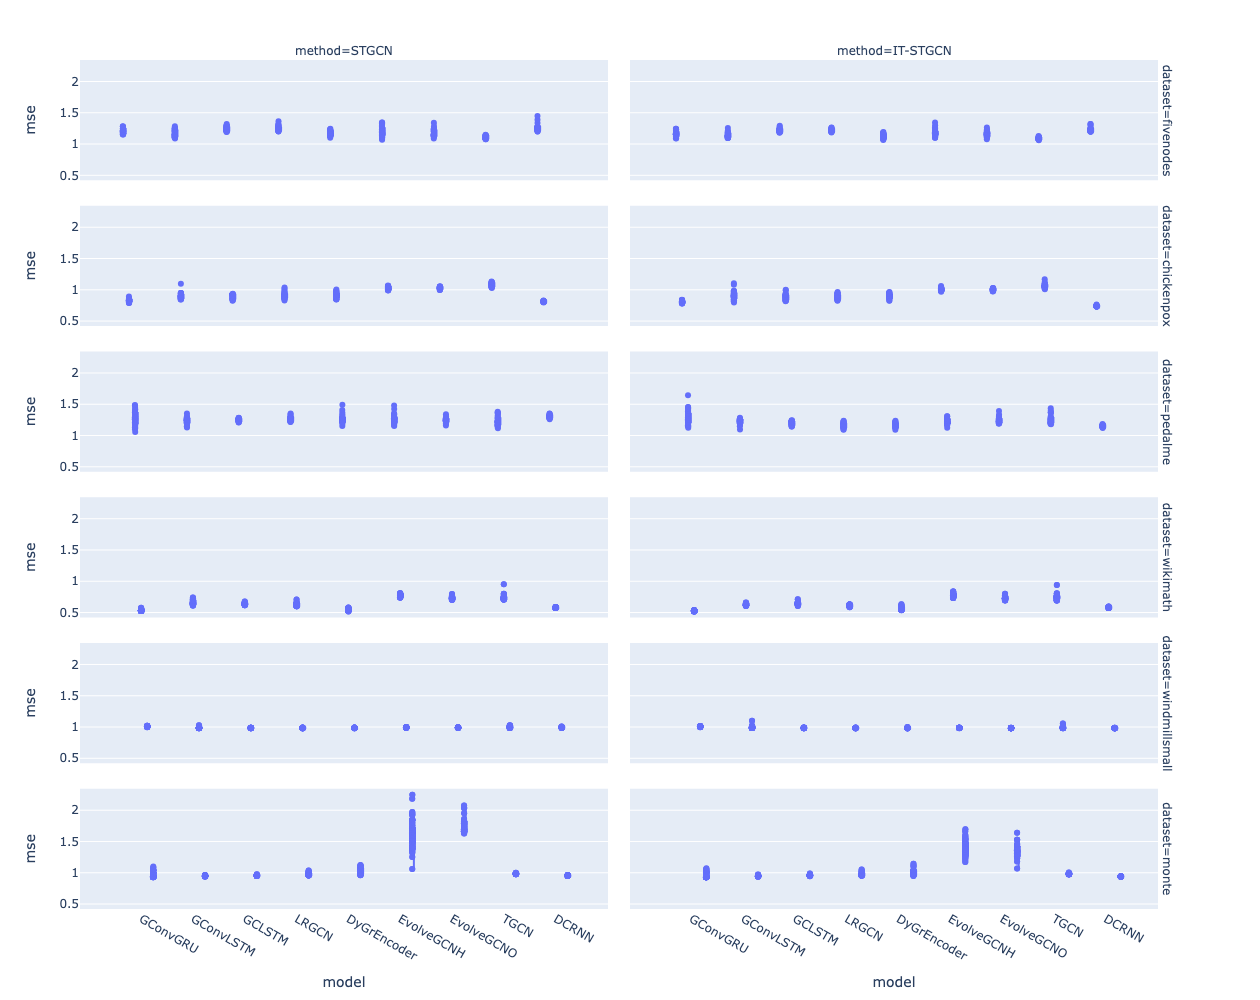

In [358]:
fig = px.box(df.query("mtype=='block'"),x='model',y='mse',facet_col='method',facet_row='dataset',points='all')
fig.update_layout(height=1000, width=1000)
fig

In [359]:
df.query("dataset=='chickenpox' and mtype=='block'").model.unique()

array(['GConvGRU', 'GConvLSTM', 'GCLSTM', 'LRGCN', 'DyGrEncoder',
       'EvolveGCNH', 'EvolveGCNO', 'TGCN', 'DCRNN'], dtype=object)